# SDS Final Data Prep

In [1]:
%matplotlib inline

In [ ]:
import datetime as dt
import itertools
import pandas as pd

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import synapseclient
from synapseclient import Activity, Schema, Table, as_table_columns

InteractiveShell.ast_node_interactivity = 'all'
syn = synapseclient.Synapse()
syn.login()

def isnum(x):
    if x is None:
        return False
    try:
        float(x)
        return True
    except ValueError:
        return False

In [ ]:
v1sid, v2sid = 'syn12181339', 'syn12181348'

v1r = pd.read_csv(syn.get(v1sid).path, parse_dates=['timestamp'])
v2r = pd.read_csv(syn.get(v2sid).path, parse_dates=['timestamp'])

v1r.head()
v2r.head()

### Process V1 Data

In [ ]:
v1 = v1r.drop(columns=['userid','timestampUTC']) \
    .rename(columns={
        'timestamp':'dt_response'
})

v1.head()

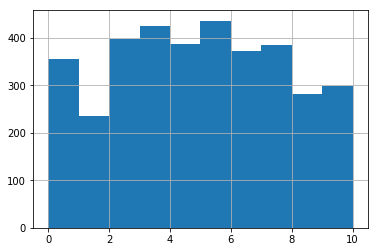

In [6]:
v1.support.hist()

### Process V2 data

In [9]:
v2 = v2r.drop(columns='userid').rename(columns={
    'brightenid':'participant_id',
    'timestamp':'dt_response'
})

v2.support = v2.support/10

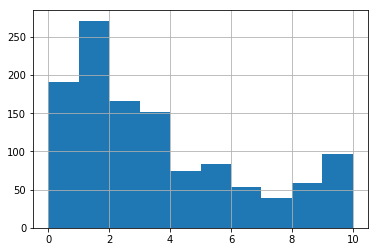

In [10]:
v2.support.hist()

### Combine the DataFrames

In [ ]:
combined = pd.concat([v1, v2], sort=False)
combined.head()

### Set provenance and upload to Synapse

In [12]:
final = syn.store(Table(
    Schema(
            name='SDS',
            columns=as_table_columns(combined), 
            parent='syn10848316'),
        combined
    )
)

In [13]:
final = syn.setProvenance(
    'syn17022658',
    activity=Activity(
        name='Combine V1 and V2 data',
        description='Process and combine the data collected during study 1 and study 2',
        used=[v1sid, v2sid],
        executed=[
            dict(
                name='IPython Notebook',
                url='https://github.com/apratap/BRIGHTEN-Data-Release/blob/master/Create_SDS_datafiles.ipynb'
            )
        ]
    )
)